Summary:
   This Model is for an Insurance company sales team. The team is given leads from their existing customer base, predominantly
   health insurance customers. With out leads prioritization, they have to contact all the leads which is in-effcient. With 
   this model, we were able to reduce the contactable leads by 50% with out leaving any potential conversions.
   
    We developed a lead prioritization model.
    
    In test data, we have total 83990 leads. With out the help of prioritization model, the sales team will have to 
    contact all these leads with a conversion rate of 13.6 % conversion rate.
    
    With the new prioritization model the conversion rate incresed by 100% to 26%.
    This will weed away 50% of leads form the sales leads.

In [106]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, \
precision_score,recall_score, roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

In [107]:
df = pd.read_csv('./train.csv')

In [108]:
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [109]:
df.drop(columns=['id'],inplace=True)

In [110]:
list_predictors = list(df.columns)
list_predictors.remove('Response')

### Data Processing 

In [111]:
def extract_numeric_ordinals(data_frame,columns):
    numeric_columns = []
    ordinal_columns = []
    for column in columns:
        if df[column].dtype !='O':
            if len(list(df[column].unique()))/df.shape[0] < 0.01:
                ordinal_columns.append(column)
            else:
                numeric_columns.append(column)
    return(numeric_columns, ordinal_columns)

In [112]:
def extract_categoricals(data_frame,columns):
    categorical_columns = []
    for column in columns:
        if df[column].dtype == 'O':
            categorical_columns.append(column)
    return(categorical_columns)

In [113]:
def categorical_ordinal_convert_to_ranked_numerical(dataframe,ordinal_columns, categorical_columns,target):
    complete_list = ordinal_columns+categorical_columns
    for column in complete_list:
        S = pd.DataFrame(dataframe.groupby(column)[target].mean().sort_values(ascending=False))
        S.reset_index(inplace=True)
        S['rank'] = S[target].rank(pct=True)
        map_dict = dict(zip(list(S[column]), list(S['rank'])))        
        df[column+'ranked_ordinal'] = df[column].map(map_dict)
        df.drop(columns=[column],inplace=True)
    return(dataframe)

In [114]:
numeric_columns, ordinal_columns = extract_numeric_ordinals(df,list_predictors)

In [115]:
categorical_columns = extract_categoricals(df,list(df.columns))

In [116]:
dataframe_processed = categorical_ordinal_convert_to_ranked_numerical(df, ordinal_columns, categorical_columns,'Response')

In [117]:
ordinal_columns

['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Policy_Sales_Channel',
 'Vintage']

In [118]:
dataframe_processed

,Annual_Premium,Response,Ageranked_ordinal,Driving_Licenseranked_ordinal,Region_Coderanked_ordinal,Previously_Insuredranked_ordinal,Policy_Sales_Channelranked_ordinal,Vintageranked_ordinal,Genderranked_ordinal,Vehicle_Ageranked_ordinal,Vehicle_Damageranked_ordinal
0,40454.0,1,0.909091,1.0,0.981132,1.0,0.812903,0.179310,1.0,1.000000,1.0
1,33536.0,0,0.303030,1.0,0.830189,1.0,0.812903,0.903448,1.0,0.666667,0.5
2,38294.0,1,0.939394,1.0,0.981132,1.0,0.812903,0.175862,1.0,1.000000,1.0
3,28619.0,0,0.075758,1.0,0.660377,0.5,0.245161,0.472414,1.0,0.333333,0.5
4,27496.0,0,0.439394,1.0,0.735849,0.5,0.245161,0.758621,0.5,0.333333,0.5
...,...,...,...,...,...,...,...,...,...,...,...
381104,30170.0,0,0.318182,1.0,0.226415,0.5,0.812903,0.055172,1.0,0.666667,0.5
381105,40016.0,0,0.515152,1.0,0.339623,0.5,0.245161,0.848276,1.0,0.333333,0.5
381106,35118.0,0,0.075758,1.0,0.245283,0.5,0.232258,0.065517,1.0,0.333333,0.5
381107,44617.0,0,0.393939,1.0,0.471698,1.0,0.774194,0.034483,0.5,1.000000,1.0


### Statistical Preprocessing

In [119]:
list_predictors = list(dataframe_processed.columns)
list_predictors.remove('Response')

In [120]:
X_predictors = df[list_predictors].to_numpy()
Y_response = df['Response'].to_numpy()

In [121]:
quantile_transformer = QuantileTransformer()
quantile_transformer.fit(X_predictors)
X_predictors_transform = quantile_transformer.transform(X_predictors)

In [122]:
X_train, X_test, Y_train , Y_test = train_test_split(X_predictors_transform, Y_response, 
                                                    stratify=Y_response, test_size=0.25, 
                                                    random_state = 42)

### Logistic Regression Model

In [123]:
LogisticModel = LogisticRegression()
C_grid=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
GridSearchModel = GridSearchCV(estimator=LogisticModel, param_grid={'C':C_grid}, 
                                                        scoring='roc_auc',cv =5 ) 
GridSearchModel.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='roc_auc')

In [124]:
print(" The best training score:{:.5f} for the model is available at param value:{:.2f}".\
                                                      format(GridSearchModel.best_score_, GridSearchModel.best_params_['C']))

 The best training score:0.84661 for the model is available at param value:1.00


In [125]:
print(" The Testscore:{:.5f} ".\
                format(roc_auc_score(Y_test,  GridSearchModel.predict_proba(X_test)[:, 1])))

 The Testscore:0.84888 


The model has comparable scores between training and test so there is no signs of over fitting.

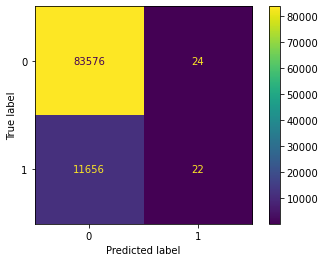

In [126]:
# Testing on validationSet
Y_test_predicted = GridSearchModel.predict(X_test)
cm = confusion_matrix(Y_test, Y_test_predicted)
ConfusionMatrixDisplay(cm).plot()

In [127]:
print("Precision:{:.2f} and Recall{:.5f} for this Model".format(precision_score(Y_test, Y_test_predicted),\
                                                        recall_score(Y_test, Y_test_predicted)))

Precision:0.48 and Recall0.00188 for this Model


The Model has AUC score of 0.85 for both test and training sets How ever, at the default probability threshold of
0.5, the precision and re-call score are not sasticfactory.

To modify the probability threshold, we will plot the ROC curve and obtain the threshold that gives best true positive rate
with least possibile true negative rate.

### Model Diagnostics

Text(0.5, 1.0, 'True Positive Curve')

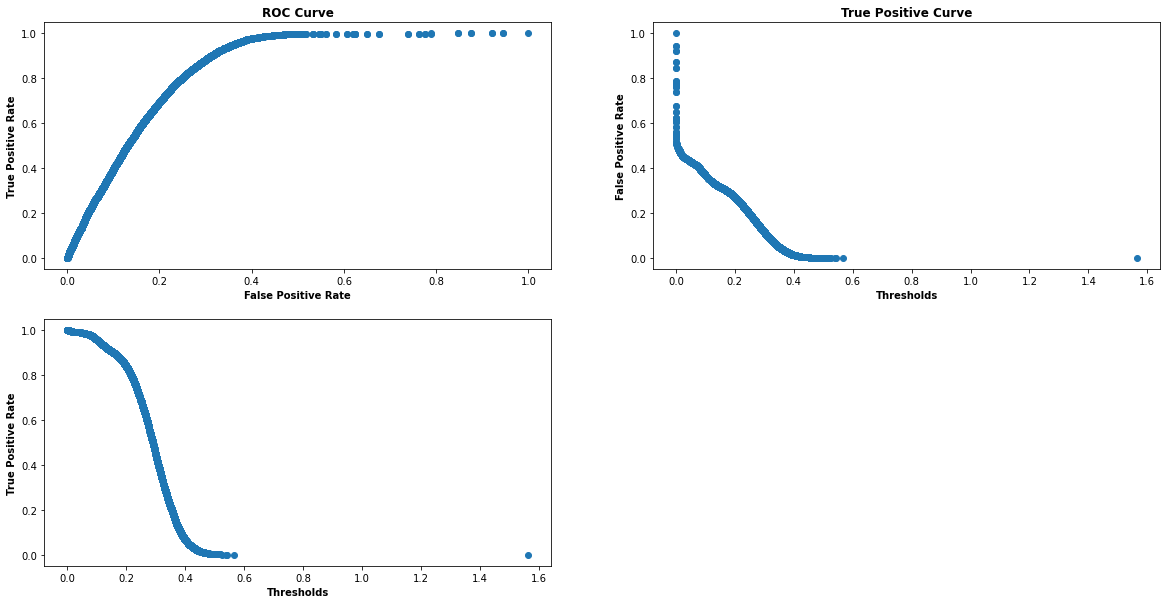

In [128]:
fpr, tpr, thresholds = roc_curve(Y_test,  GridSearchModel.predict_proba(X_test)[:, 1])
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
ax3 = fig1.add_subplot(2,2,3)
ax1.scatter(x = fpr, y = tpr)
ax1.set_xlabel("False Positive Rate", weight='bold')
ax1.set_ylabel("True Positive Rate", weight='bold')
ax1.set_title("ROC Curve", weight='bold')
ax2.scatter(x = thresholds, y = fpr)
ax2.set_xlabel("Thresholds", weight='bold')
ax2.set_ylabel("False Positive Rate", weight='bold')
ax2.set_title("True Positive Curve", weight='bold')
ax3.scatter(x = thresholds, y = tpr)
ax3.set_xlabel("Thresholds", weight='bold')
ax3.set_ylabel("True Positive Rate", weight='bold')
ax2.set_title("True Positive Curve", weight='bold')

The goal of machine learning model is to balance between True positive rate and false positive rate. As true positive rate
increases,which is desired, the false positive rate increases too. So we should determine the threshold that maximizes True 
positive rate with the least false positive rate. 

The ROC surve is flattening at FPR of 0.4. This means 40% of label zero will be labelled as positive. Given that this is a lead
priorotisation model, this threshold eliminaated 60% of the leads while ensuring that all the potential conversions are captured.

Text(0.5, 1.0, 'True Positive Curve')

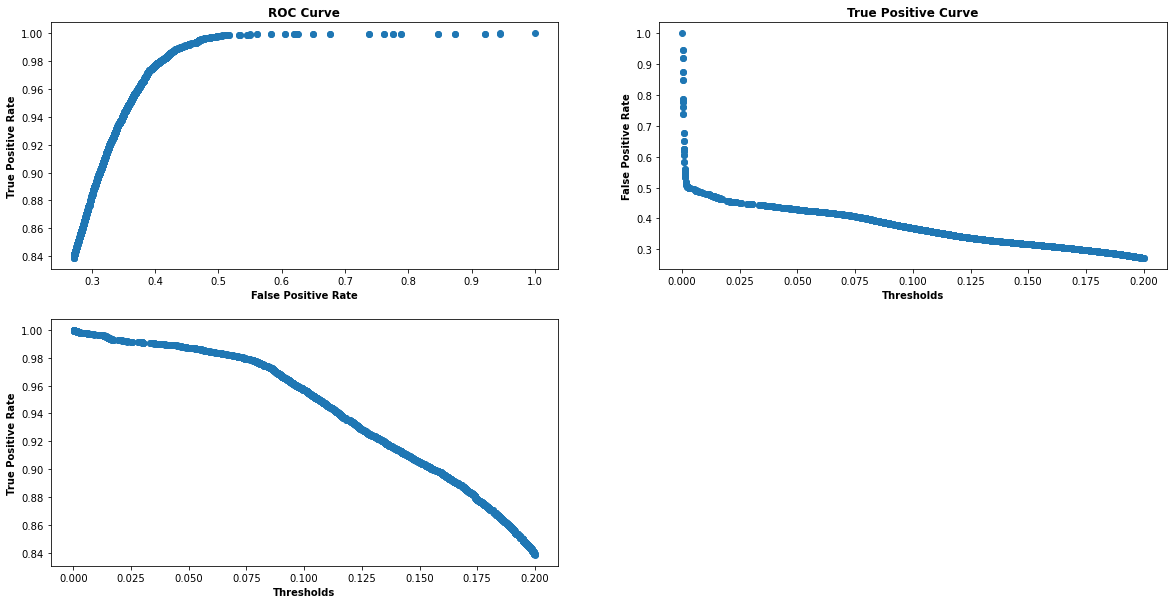

In [129]:
# Exploring Thresholds below 0.2 for more focused TPR and FPR.

fpr, tpr, thresholds = roc_curve(Y_test,  GridSearchModel.predict_proba(X_test)[:, 1])
df_performance  = pd.DataFrame({'FalsePositiveRate':fpr, 'TruePositiveRate':tpr, 'Thresholds':thresholds})
df_performance = df_performance[df_performance["Thresholds"].between(0,0.2)]
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
ax3 = fig1.add_subplot(2,2,3)
ax1.scatter(x = df_performance["FalsePositiveRate"], y = df_performance["TruePositiveRate"])
ax1.set_xlabel("False Positive Rate", weight='bold')
ax1.set_ylabel("True Positive Rate", weight='bold')
ax1.set_title("ROC Curve", weight='bold')
ax2.scatter(x = df_performance["Thresholds"], y = df_performance["FalsePositiveRate"], )
ax2.set_xlabel("Thresholds", weight='bold')
ax2.set_ylabel("False Positive Rate", weight='bold')
ax2.set_title("True Positive Curve", weight='bold')
ax3.scatter(x = df_performance["Thresholds"], y = df_performance["TruePositiveRate"], )
ax3.set_xlabel("Thresholds", weight='bold')
ax3.set_ylabel("True Positive Rate", weight='bold')
ax2.set_title("True Positive Curve", weight='bold')

Looking closely, we find that at threshold of 0.075, the False positive rate is 0.4 and 0.97 True positive rate. We will 
this as threshold for classifier and look at the confusion matrix.

In [130]:
Y_predicted_probability = GridSearchModel.predict_proba(X_test)[:, 1]
Y_pred_Threshold_new = np.where(Y_predicted_probability>=0.075,1, 0)

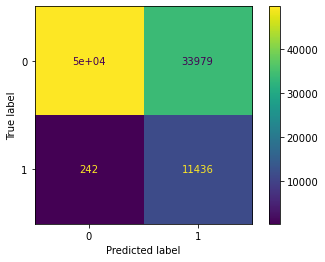

In [131]:
cm = confusion_matrix(Y_test, Y_pred_Threshold_new)
ConfusionMatrixDisplay(cm).plot()